# 0.0 Imports

In [96]:
import pandas as pd
import inflection 
import math
import numpy as np
import seaborn as sns
import datetime as datetime 

from scipy import stats
from matplotlib import pyplot as plt
from IPython.core.display import HTML
from IPython.display import Image

# Define as configurações padrão do Seaborn
sns.set(style='whitegrid', rc={'figure.figsize': (22, 10)})

time: 0 ns (started: 2023-07-08 08:00:42 -03:00)


## 0.1 Helper Functions

In [94]:
def cramer_v( x, y ):
    cm = pd.crosstab( x, y).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency( cm )[0]
    
    chi2corr = max( 0, chi2 - (k-1) * (r-1) / (n-1))
    
    kcorr = k - (k-1)**2/(n-1)
    
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt( (chi2corr/n) / (min( kcorr-1, rcorr-1 ) ) )



time: 0 ns (started: 2023-07-08 08:00:07 -03:00)


## 0.2 Loading Data

In [2]:
df_sales_raw = pd.read_csv('data/train.csv', low_memory=False)
df_store_raw = pd.read_csv('data/store.csv', low_memory=False)

# merge
df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store' )

time: 766 ms (started: 2023-07-08 07:15:26 -03:00)


# 1.0 Descrição dos dados

In [3]:
df1 = df_raw.copy()

time: 156 ms (started: 2023-07-08 07:15:26 -03:00)


In [4]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
            'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
            'CompetitionDistance', 'CompetitionOpenSinceMonth',
            'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
            'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore( x )

cols_new = list(map( snakecase, cols_old))

#rename

df1.columns = cols_new

time: 0 ns (started: 2023-07-08 07:15:26 -03:00)


In [5]:
df1.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

time: 16 ms (started: 2023-07-08 07:15:26 -03:00)



## 1.1 Rename Columns


## 1.2 Data dimensions

In [6]:
print ('Number of Rows: {}'.format( df1.shape[0]))
print ('Number of Columns: {}'.format( df1.shape[1]))

Number of Rows: 1017209
Number of Columns: 18
time: 0 ns (started: 2023-07-08 07:15:26 -03:00)



## 1.3 Data types

In [7]:

df1['date'] = pd.to_datetime( df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

time: 125 ms (started: 2023-07-08 07:15:27 -03:00)



## 1.4 Check NA

In [8]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

time: 407 ms (started: 2023-07-08 07:15:27 -03:00)



## 1.5 Fillout NA

In [9]:
df1.sample()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval
137500,356,1,2015-03-30,9149,563,1,1,0,1,d,c,8970.0,12.0,2007.0,1,22.0,2012.0,"Feb,May,Aug,Nov"


time: 62 ms (started: 2023-07-08 07:15:27 -03:00)


In [10]:
#competition_distance   
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

#competition_open_since_month    
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'],axis=1)

#competition_open_since_year     
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'],axis=1)

#promo2_since_week                
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'],axis=1)

# promo2_since_year     
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'],axis=1)

# promo_interval 
month_map = {1: 'Jan',2: 'Fev',3: 'Mar',4: 'Apr',5: 'May',6: 'Jun',7: 'Jul',8: 'Aug',9: 'Sep',10: 'Oct',11: 'Nov',12: 'Dec'}

df1['promo_interval'].fillna(0, inplace=True)

df1['month_map'] = df1['date'].dt.month.map( month_map )

df1['is_promo'] =  df1[['promo_interval','month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split( ',') else 0, axis=1)









time: 45.8 s (started: 2023-07-08 07:15:27 -03:00)


## 1.6 Change Types

In [11]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

time: 0 ns (started: 2023-07-08 07:16:13 -03:00)


In [12]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( int )
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype( int )

df1['promo2_since_week'] = df1['promo2_since_week'].astype( int )
df1['promo2_since_year'] = df1['promo2_since_year'].astype( int )

time: 31 ms (started: 2023-07-08 07:16:13 -03:00)


## 1.7 Descriptive Statistical

In [13]:
num_attributes = df1.select_dtypes( include=['int64', 'float64'])
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64','datetime64[ns]'])

time: 78 ms (started: 2023-07-08 07:16:13 -03:00)


In [14]:
cat_attributes.sample(2)

,state_holiday,store_type,assortment,competition_open_since_month,competition_open_since_year,promo2_since_week,promo2_since_year,promo_interval,month_map
72420,0,d,c,5,2015,22,2015,0,May
506770,0,d,c,10,2008,39,2010,"Feb,May,Aug,Nov",Apr


time: 31 ms (started: 2023-07-08 07:16:13 -03:00)


## 1.7.1 Numerical Attributes

In [15]:
# Central tendency - mean, median
ct1 = pd.DataFrame(num_attributes.apply( np.mean )).T
ct2 = pd.DataFrame(num_attributes.apply( np.median )).T

# Dispersion - std, min, max, range, skew, curtosis

d1 = pd.DataFrame(num_attributes.apply( np.std )).T
d2 = pd.DataFrame(num_attributes.apply( min )).T
d3 = pd.DataFrame(num_attributes.apply( max )).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min() )).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew() )).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis() )).T

# concatenate
m = pd.concat( [d2, d3, d4 , ct1, ct2, d1, d5, d6]).T.reset_index()

m.columns =  ['attributes','min','max','range','mean','median','std','skew','kurtosis']

m



,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,promo2,0.0,1.0,1.0,0.500564,1.0,0.500000,-0.002255,-1.999999
9,is_promo,0.0,1.0,1.0,0.155231,0.0,0.362124,1.904152,1.625796


time: 1.52 s (started: 2023-07-08 07:16:13 -03:00)


C:\Users\acordeiro\AppData\Local\Temp\ipykernel_3752\2697858400.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot( df1['competition_distance'])


<Axes: xlabel='competition_distance', ylabel='Density'>

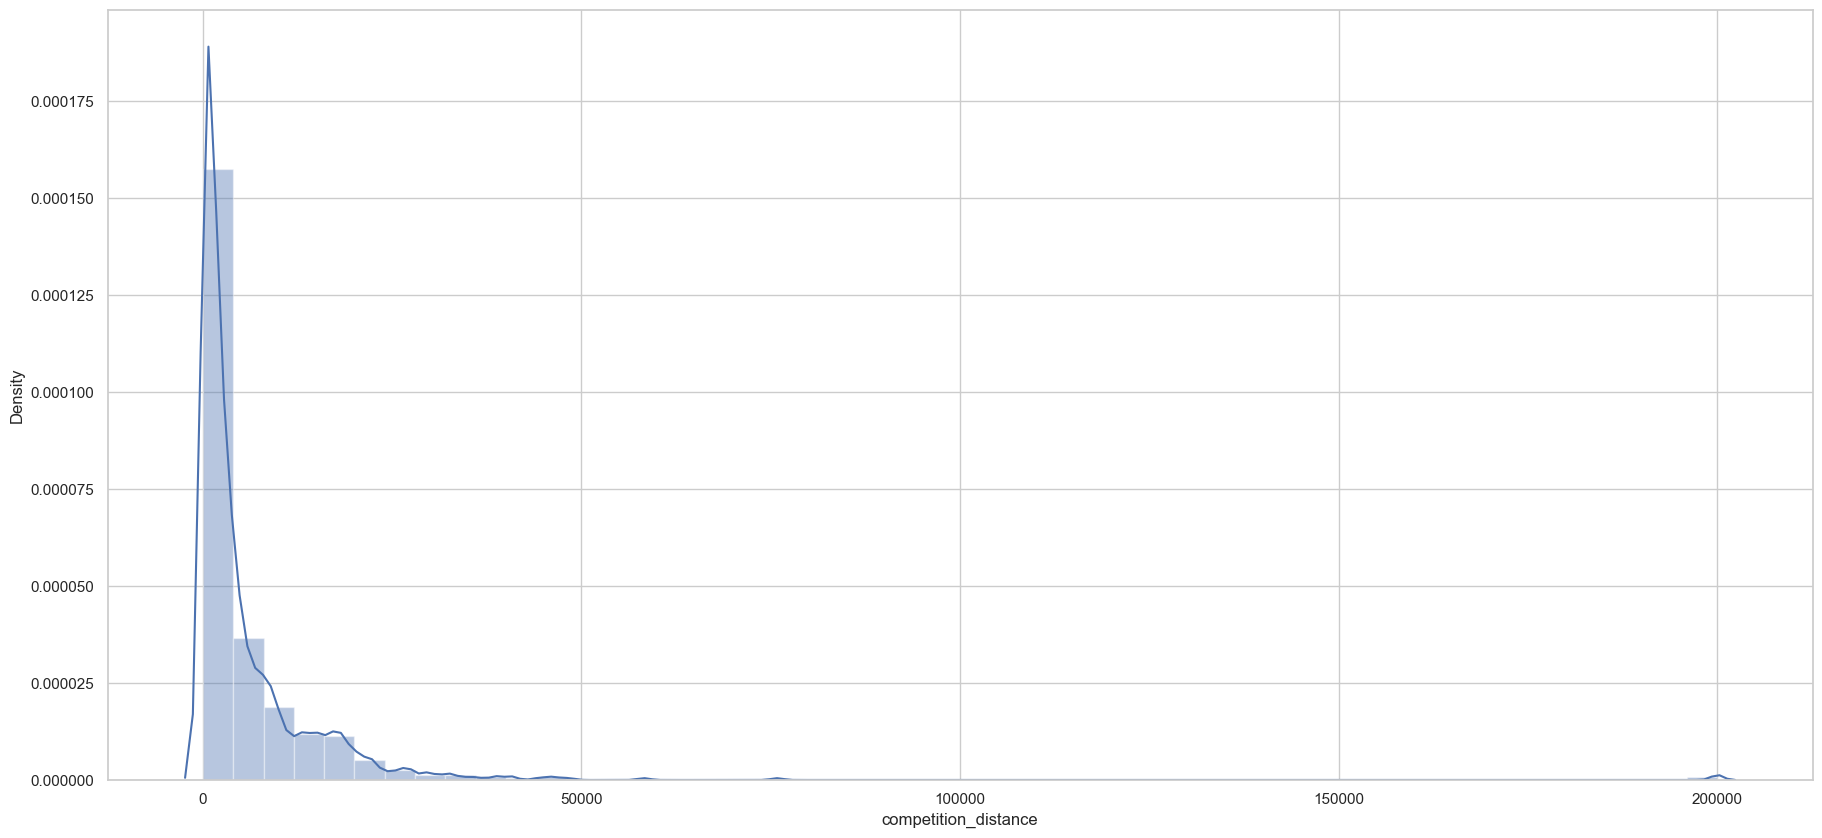

time: 9.61 s (started: 2023-07-08 07:16:15 -03:00)


In [16]:
sns.distplot( df1['competition_distance'])

## 1.7.2 Categorical Attributes

In [17]:
cat_attributes.apply( lambda x: x.unique().shape[0])

state_holiday                    4
store_type                       4
assortment                       3
competition_open_since_month    12
competition_open_since_year     23
promo2_since_week               52
promo2_since_year                7
promo_interval                   4
month_map                       12
dtype: int64

time: 187 ms (started: 2023-07-08 07:16:24 -03:00)


<Axes: xlabel='assortment', ylabel='sales'>

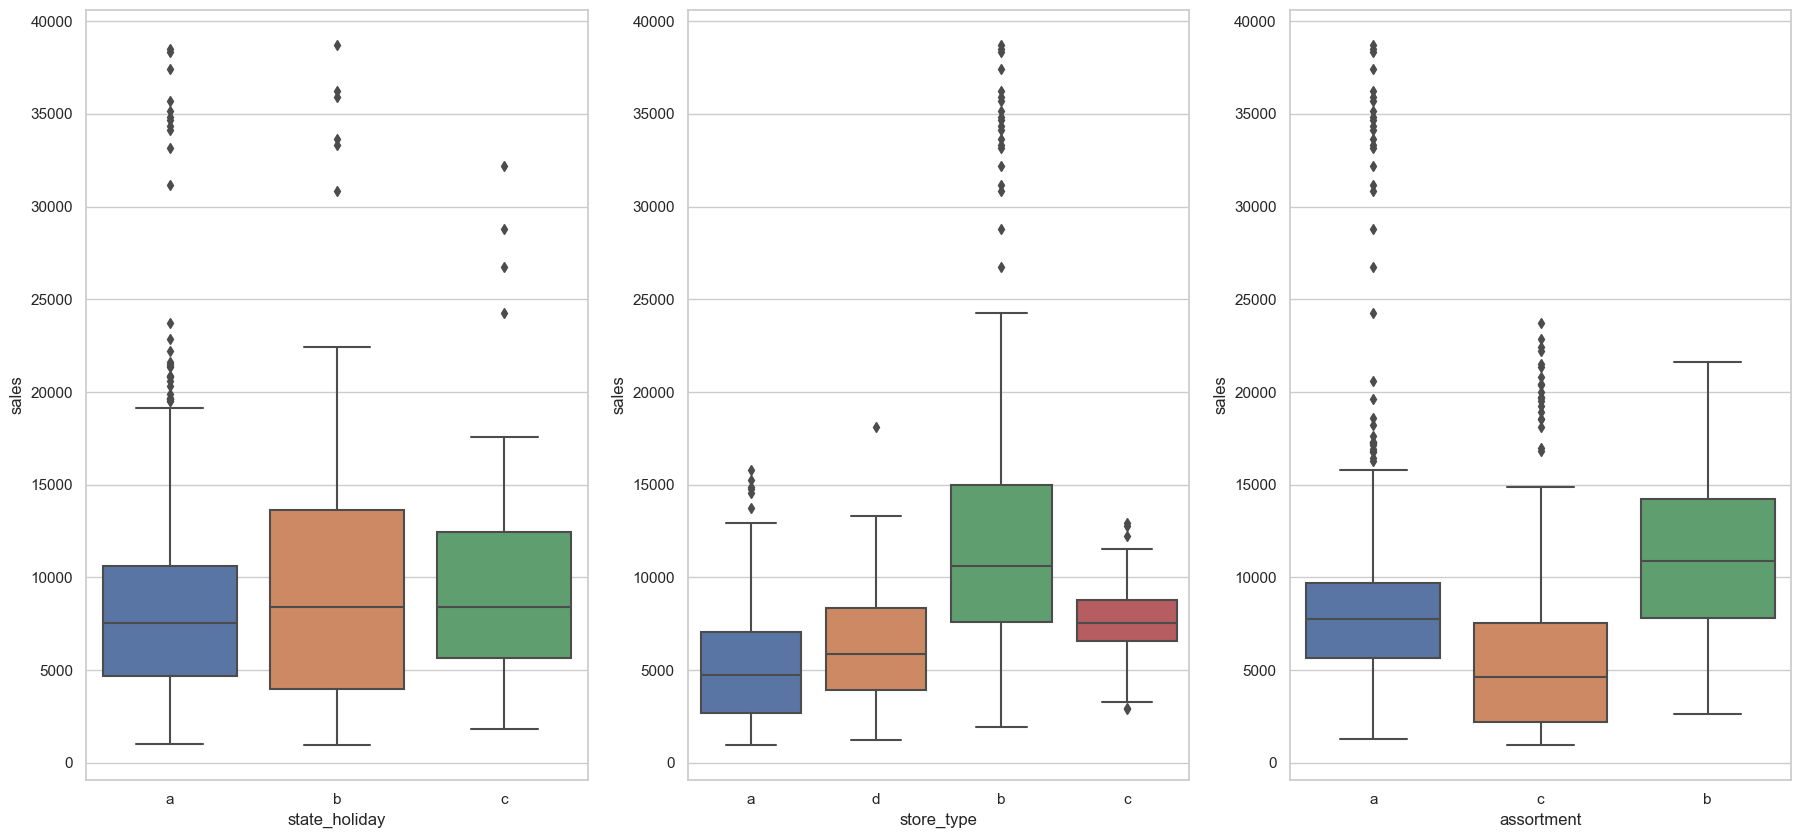

time: 609 ms (started: 2023-07-08 07:16:25 -03:00)


In [18]:
aux1 = df1[(df1['state_holiday'] != '0' ) & (df1[ 'sales'] >0)]

plt.subplot(1, 3, 1)
sns.boxplot( x='state_holiday', y='sales', data=aux1)

plt.subplot(1, 3, 2)
sns.boxplot( x='store_type', y='sales', data=aux1)

plt.subplot(1, 3, 3)
sns.boxplot( x='assortment', y='sales', data=aux1)

# 2.0 Feature Engineering 

In [19]:
df2 = df1.copy()

time: 62 ms (started: 2023-07-08 07:16:25 -03:00)


## 2.1 Criação das hipoteses

### 2.1.1 Hipoteses Loja

**1.** Lojas com maior quadro de funcionarios deveriam vender mais.

**2.** Lojas com maior estoque deveriam vender mais.

**3.** Lojas com maior porte deveriam vender mais.

**4.** Lojas com menor porte deveriam vender menos.

**5.** Lojas com maior sortimento deveriam vender mais.

### 2.1.2 Hipoteses Produto

**1.** Lojas que investem mais em marketing deveriam vender mais.

**2.** Lojas que expoe mais os produtos nas vitrines deveriam vender mais.

**3.** Lojas que tem preco menores nos produtos deveriam vender mais.

**4.** Lojas que tem precos menores por mais tempo nos produtos deveriam vender mais.


### 2.1.3 Hipoteses Tempo

**1.** Lojas que tem mais feriados deveriam vender menos. 

**2.** Lojas que abrem nos primeiros 6 meses deveriam vender mais.

**3.** Lojas que abrem nos finais de semana deveriam vender mais.

## 2.2 Lista final de Hipoteses

**1.** Lojas com maior sortimentos deveriam vender mais.

**2.** Lojas com comptidores mais próximos deveriam vender menos.

**3.** Lojas com competidores á mais tempo deveriam vender mais.

**4.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**5.** Lojas com mais dias de promoção deveriam vender mais. 

**6.** Lojas com mais promoções consectuvas deveriam vender mais.

**7.** Lojas abertas durantes o feriado de nataval deveriam vender mais. 

**8.** Lojas deveriam vender mais ao longo dos anos. 

**9.** Lojas deveriam mais no segundo semestre do ano. 

**10.** Lojas deveriam vender mais depois do dia 10 de cada mês. 

**11.** Lojas deveriam vender menos aos finais de semana. 

**12.** Lojas deveriam vender menos durante os feriados escolares.


## 2.3 Feature Engineering

In [20]:
# year
df2['year'] = df2['date'].dt.year 

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.weekofyear

# year week
df2['year_week'] = df2['date'].dt.strftime( '%Y-%W')

# competition since
df2['competition_since'] =  df2.apply(lambda x: datetime.datetime (year=x['competition_open_since_year'],month=x['competition_open_since_month'] ,day=1),axis=1)
df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).apply( lambda x: x.days ).astype( int )

# promo since 
df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w') -datetime.timedelta( days=7) )
df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'])/7).apply( lambda x: x.days ).astype( int )

# assortment
df2['assortment'] = df2['assortment'].apply (lambda x: 'basic' if x=='a' else 'extra' if x=='b' else 'extended') 

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')

C:\Users\acordeiro\AppData\Local\Temp\ipykernel_3752\1657840466.py:11: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df2['week_of_year'] = df2['date'].dt.weekofyear


time: 28.7 s (started: 2023-07-08 07:16:25 -03:00)


In [21]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


time: 16 ms (started: 2023-07-08 07:16:54 -03:00)


# 3.0 Filtragem de variaveis

In [22]:
df3 = df2.copy()

time: 172 ms (started: 2023-07-08 07:16:54 -03:00)


## 3.1 Filtragem das linhas

In [23]:
df3.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,...,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,...,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,...,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,...,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,...,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,...,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


time: 16 ms (started: 2023-07-08 07:16:54 -03:00)


In [24]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

time: 110 ms (started: 2023-07-08 07:16:54 -03:00)


## 3.2 Selecao das colunas

In [25]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']

df3 = df3.drop( cols_drop, axis=1)

time: 94 ms (started: 2023-07-08 07:16:54 -03:00)


In [26]:
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

time: 0 ns (started: 2023-07-08 07:16:54 -03:00)


# 4.0 Analise exploratória dos dados

In [27]:
df4 = df3.copy()

time: 47 ms (started: 2023-07-08 07:16:54 -03:00)


## 4.1 Analise univariada


### 4.1.1 Response variable


C:\Users\acordeiro\AppData\Local\Temp\ipykernel_3752\1267050350.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot( df4['sales'] ,kde=False )


<Axes: xlabel='sales'>

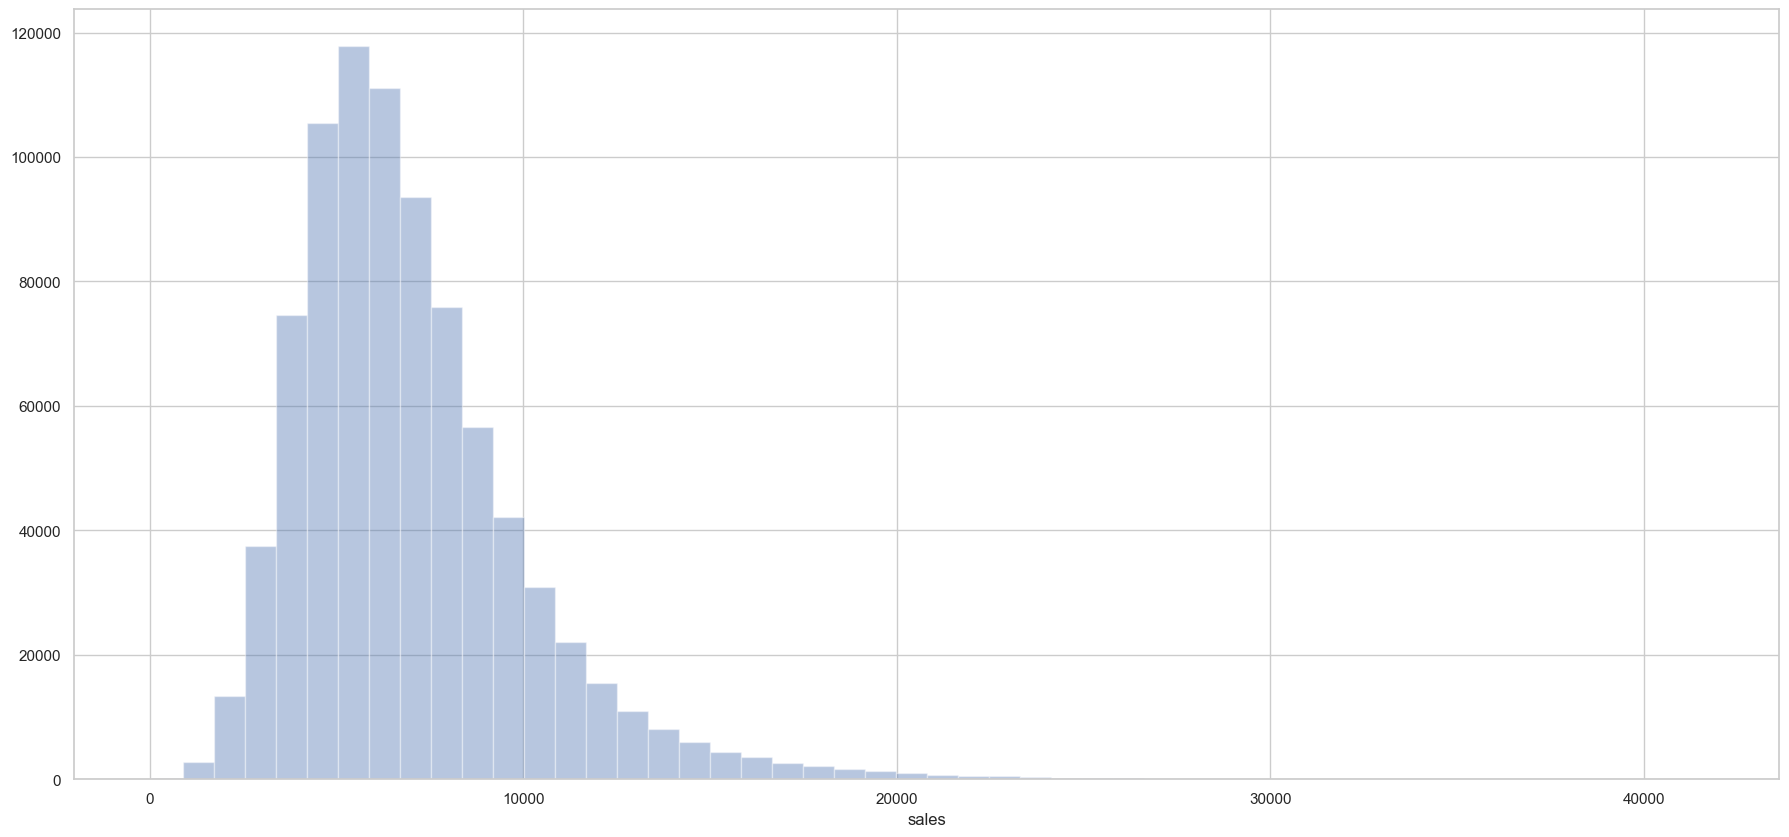

time: 359 ms (started: 2023-07-08 07:16:55 -03:00)


In [28]:
sns.distplot( df4['sales'] ,kde=False )  

### 4.1.2 Numerical Variable


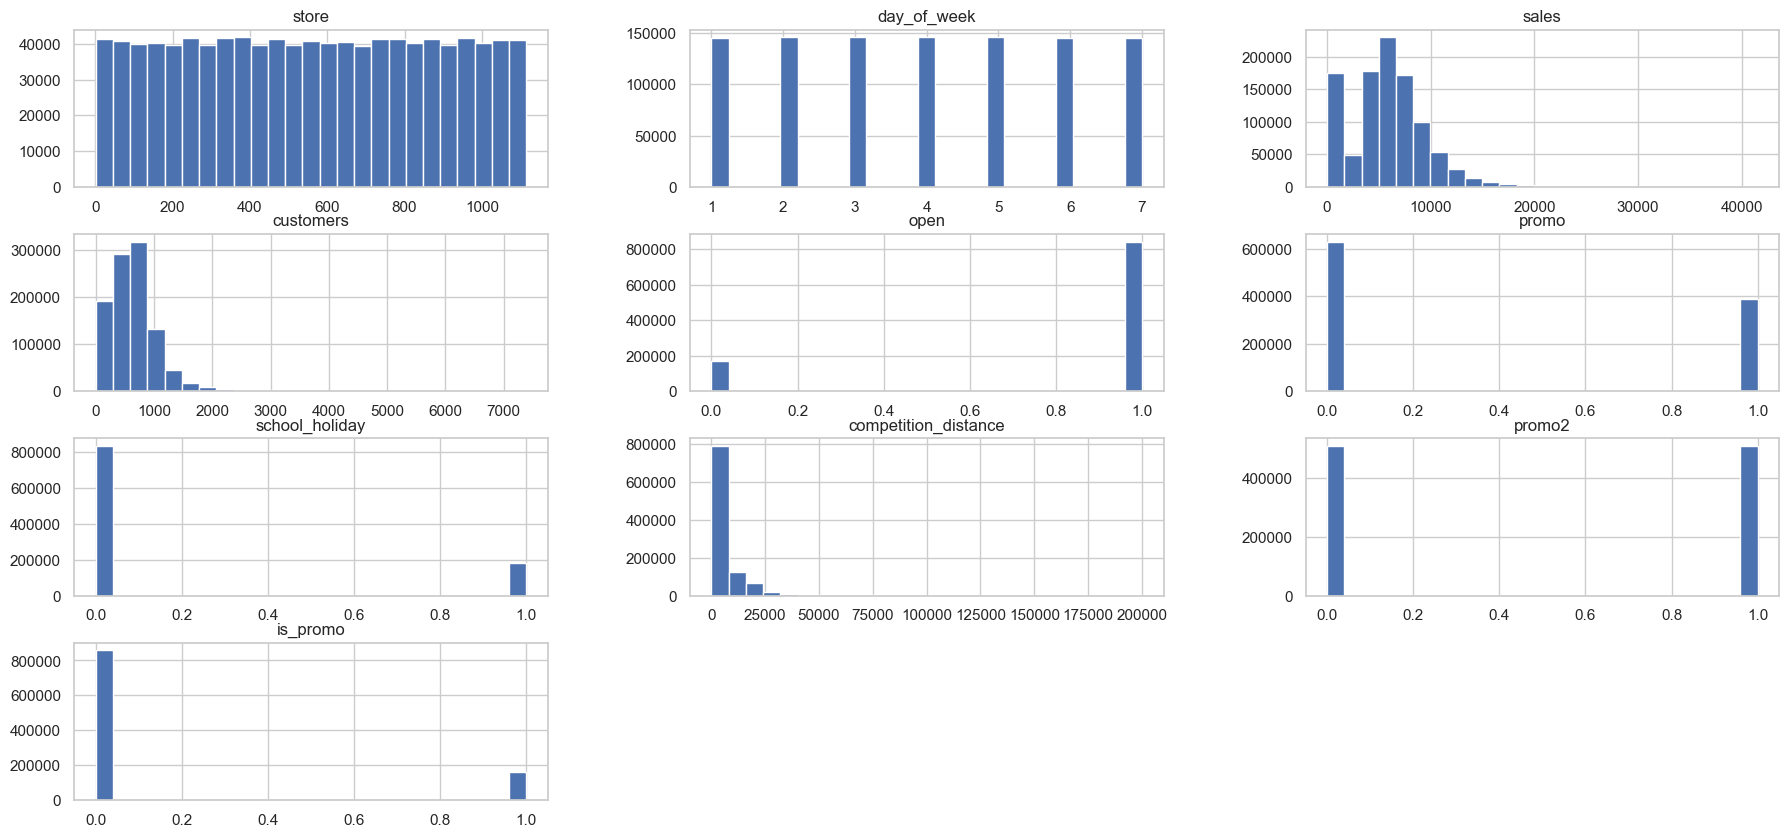

time: 2.47 s (started: 2023-07-08 07:16:55 -03:00)


In [29]:
num_attributes.hist( bins=25);

### 4.1.3 Categorical Variable


In [30]:
df4['state_holiday'].drop_duplicates()
df4['store_type'].drop_duplicates()
df4['assortment'].drop_duplicates()

0         basic
3      extended
258       extra
Name: assortment, dtype: object

time: 47 ms (started: 2023-07-08 07:16:57 -03:00)


C:\Users\acordeiro\AppData\Local\Temp\ipykernel_3752\2324957457.py:9: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot( df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', shade=True)
C:\Users\acordeiro\AppData\Local\Temp\ipykernel_3752\2324957457.py:10: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot( df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', shade=True)
C:\Users\acordeiro\AppData\Local\Temp\ipykernel_3752\2324957457.py:11: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot( df4[df4['state_holiday'] == 'christmas_holiday']['sales'], label='christmas_holiday', shade

ValueError: num must be an integer with 1 <= num <= 4, not 5

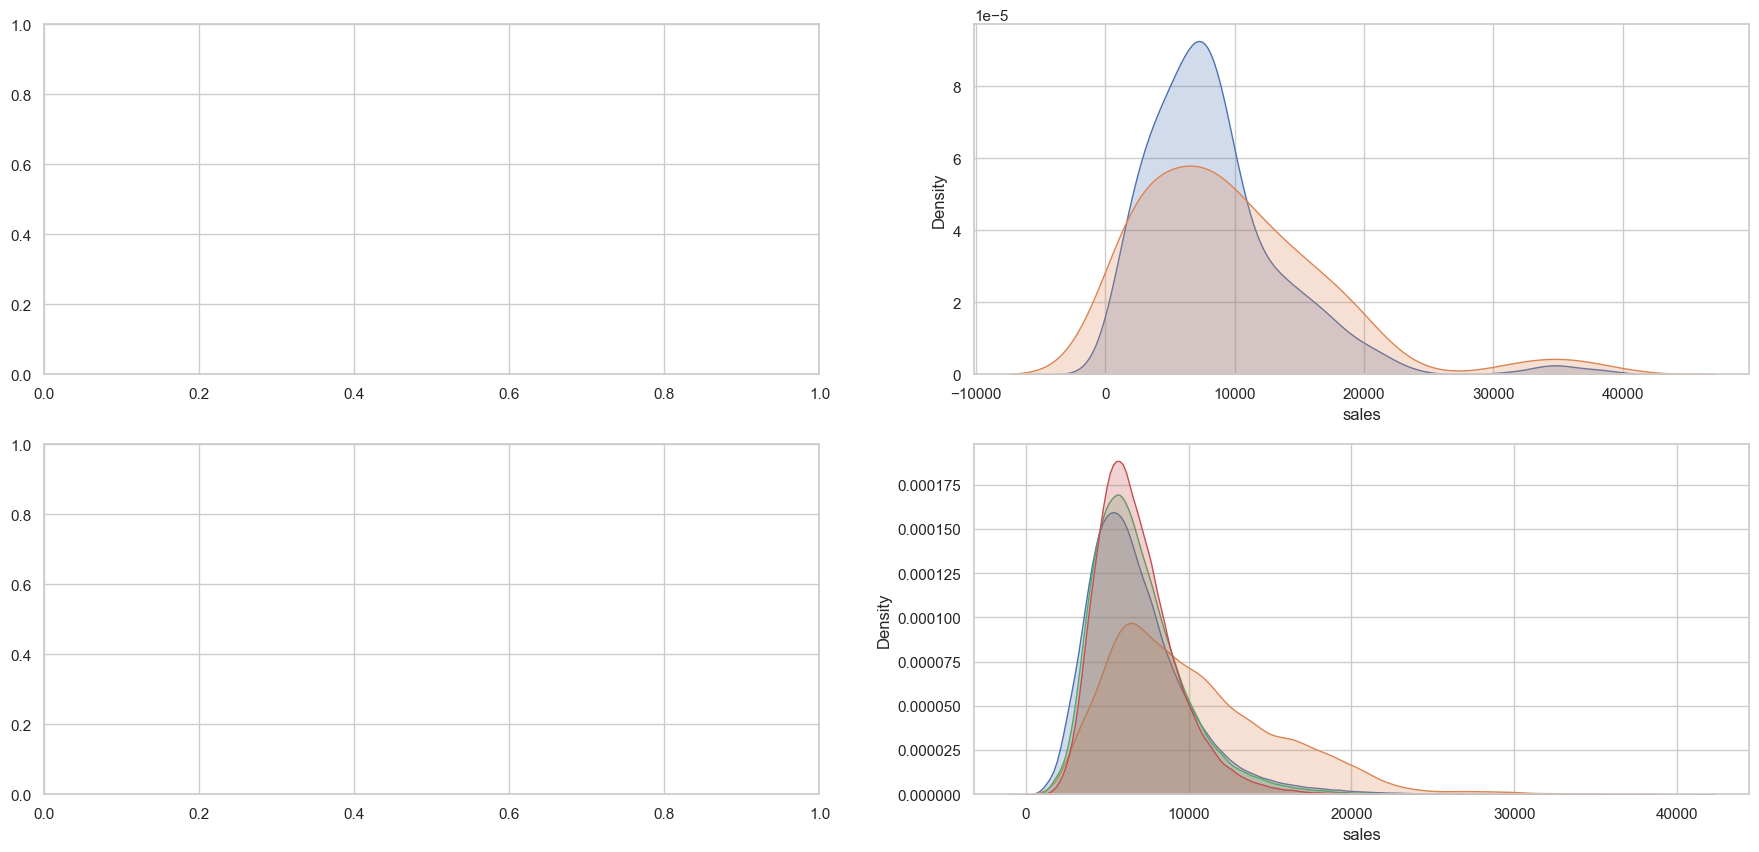

time: 9.16 s (started: 2023-07-08 07:16:57 -03:00)


In [31]:
# state holiday
plt.subplot( 2, 2, 1 )
a = df4[df4['state_holiday'] != 'regular_day']
#sns.countplot( a['state_holiday'] )



plt.subplot( 2, 2, 2 )
sns.kdeplot( df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', shade=True)
sns.kdeplot( df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', shade=True)
sns.kdeplot( df4[df4['state_holiday'] == 'christmas_holiday']['sales'], label='christmas_holiday', shade=True)

# store type
plt.subplot( 2, 2, 3 )
#sns.countplot( df4['store_type'] )

plt.subplot( 2, 2, 4 )
sns.kdeplot( df4[df4['store_type'] == 'a']['sales'], label='a', shade=True)
sns.kdeplot( df4[df4['store_type'] == 'b']['sales'], label='b', shade=True)
sns.kdeplot( df4[df4['store_type'] == 'c']['sales'], label='c', shade=True)
sns.kdeplot( df4[df4['store_type'] == 'd']['sales'], label='d', shade=True)

# assortment
plt.subplot( 2, 2, 5 )
#sns.countplot( df4['assortment'] )

plt.subplot( 2, 2, 6 )
sns.kdeplot( df4[df4['assortment'] == 'extended']['sales'], label='extended', shade=True)
sns.kdeplot( df4[df4['assortment'] == 'basic']['sales'], label='basic', shade=True)
sns.kdeplot( df4[df4['assortment'] == 'extra']['sales'], label='extra', shade=True)



## 4.2 Analise bivariada

### **H1.** Lojas com maior sortimentos deveriam vender mais.
**Falsa** Lojas com maior sortimento vendem menos

In [ ]:
aux1 = df4[['assortment','sales']].groupby('assortment').sum().reset_index()
sns.barplot( x='assortment', y='sales', data=aux1)

aux2 = df4[['year_week','assortment','sales']].groupby(['year_week','assortment']).sum().reset_index()
aux2.pivot(index='year_week', columns='assortment', values='sales').plot()

aux3 = aux2[aux2['assortment'] =='extra']
aux3.pivot(index='year_week', columns='assortment', values='sales').plot()


In [ ]:
aux2.head()

### H2.Lojas com comptidores mais próximos deveriam vender menos.
**Falsa** Lojas com competidores mais próximos vendem MAIS e não menos


In [ ]:
aux1 = df4[['competition_distance','sales']].groupby( 'competition_distance' ).sum().reset_index()

plt.subplot( 1, 3, 1 )
sns.scatterplot(x = 'competition_distance', y='sales', data=aux1);

plt.subplot( 1, 3, 2 )
bins = list( np.arange(0, 20000, 1000) )

aux1['competition_distance_binned'] = pd.cut( aux1['competition_distance'], bins=bins )
aux2 = aux1[['competition_distance_binned','sales']].groupby( 'competition_distance_binned' ).sum().reset_index()
 
sns.barplot(x='competition_distance_binned', y='sales', data=aux2);
plt.xticks(rotation=90)

plt.subplot( 1, 3, 3 )

sns.heatmap( aux1.corr (method='pearson'), annot=True)


In [ ]:
aux1.head()

### **H3.** Lojas com competidores á mais tempo deveriam vender mais.
**Falsa** Lojas com competidores há mais tempo vendem MENOS.

In [ ]:
plt.subplot(1, 3, 1)
aux1 = df4[['competition_time_month','sales']].groupby('competition_time_month').sum().reset_index()
aux2= aux1[(aux1['competition_time_month']< 120) & (aux1['competition_time_month'] != 0)]
plt.xticks(rotation=90)
sns.barplot( x='competition_time_month', y='sales', data=aux2);

plt.subplot(1, 3, 2)
sns.regplot( x='competition_time_month', y='sales', data=aux2);

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True)



### **H7.** Lojas abertas durantes o feriado de nataval deveriam vender mais.
**Falsa** Lojas abertas durante o feriado de natal vendem menos.


In [ ]:
aux = df4[df4['state_holiday'] != 'regular_day']

plt.subplot(1, 2, 1)
aux1 = aux[['state_holiday','sales']].groupby('state_holiday').sum().reset_index()
sns.barplot( x='state_holiday',y='sales', data=aux1);

plt.subplot(1, 2, 2)
aux2 = aux[['year','state_holiday','sales']].groupby(['year','state_holiday']).sum().reset_index()
sns.barplot(x='year',y='sales',hue='state_holiday',data=aux2);

### **H8.** Lojas deveriam vender mais ao longo dos anos.
**Falsa** Lojas vendem menos ao longo dos anos

In [ ]:
aux1 = df4[['year','sales']].groupby('year').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x='year',y='sales', data=aux1);

plt.subplot(1,3,2)
sns.regplot(x='year',y='sales', data=aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr (method='pearson'), annot=True);



### **H9**. Lojas deveriam mais no segundo semestre do ano.
**Falsa** Lojas vendem menos no segundo semestre do ano.


In [ ]:
aux1 = df4[['month','sales']].groupby('month').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x='month',y='sales', data=aux1);

plt.subplot(1,3,2)
sns.regplot(x='month',y='sales', data=aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr (method='pearson'), annot=True);



### **H10**. Lojas deveriam vender mais depois do dia 10 de cada mês.
**Verdadeira**

In [ ]:
aux1 = df4[['day','sales']].groupby('day').sum().reset_index()

plt.subplot(2,2,1)
sns.barplot(x='day',y='sales', data=aux1);

plt.subplot(2,2,2)
sns.regplot(x='day',y='sales', data=aux1);

plt.subplot(2,2,3)
sns.heatmap(aux1.corr (method='pearson'), annot=True);

aux1['before_after'] = aux1['day'].apply( lambda x: 'before_10_days' if x <= 10 else 'after_10_days')

plt.subplot(2,2,4)
aux2 = aux1[['before_after','sales']].groupby('before_after').sum().reset_index()

sns.barplot(x='before_after',y='sales',data=aux2);


### **H11**. Lojas deveriam vender menos aos finais de semana.
**Verdadeira**


In [ ]:
aux1 = df4[['day_of_week','sales']].groupby('day_of_week').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x='day_of_week',y='sales', data=aux1);

plt.subplot(1,3,2)
sns.regplot(x='day_of_week',y='sales', data=aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr (method='pearson'), annot=True);



### **H12**. Lojas deveriam vender menos durante os feriados escolares.
**Verdadeira** Lojas vendem menos durantes os feriados escolares, exceto nos feriados de julho e agosto

In [ ]:
plt.subplot(2,1,1)
aux1 = df4[['school_holiday','sales']].groupby('school_holiday').sum().reset_index()
sns.barplot(x='school_holiday',y='sales',data=aux1);

plt.subplot(2,1,2)
aux2 = df4[['month','school_holiday','sales']].groupby(['month','school_holiday']).sum().reset_index()
sns.barplot(x='month',y='sales',hue='school_holiday',data=aux2);

## 4.3 Analise multivariada

## 4.3.1 Numerical Attributes

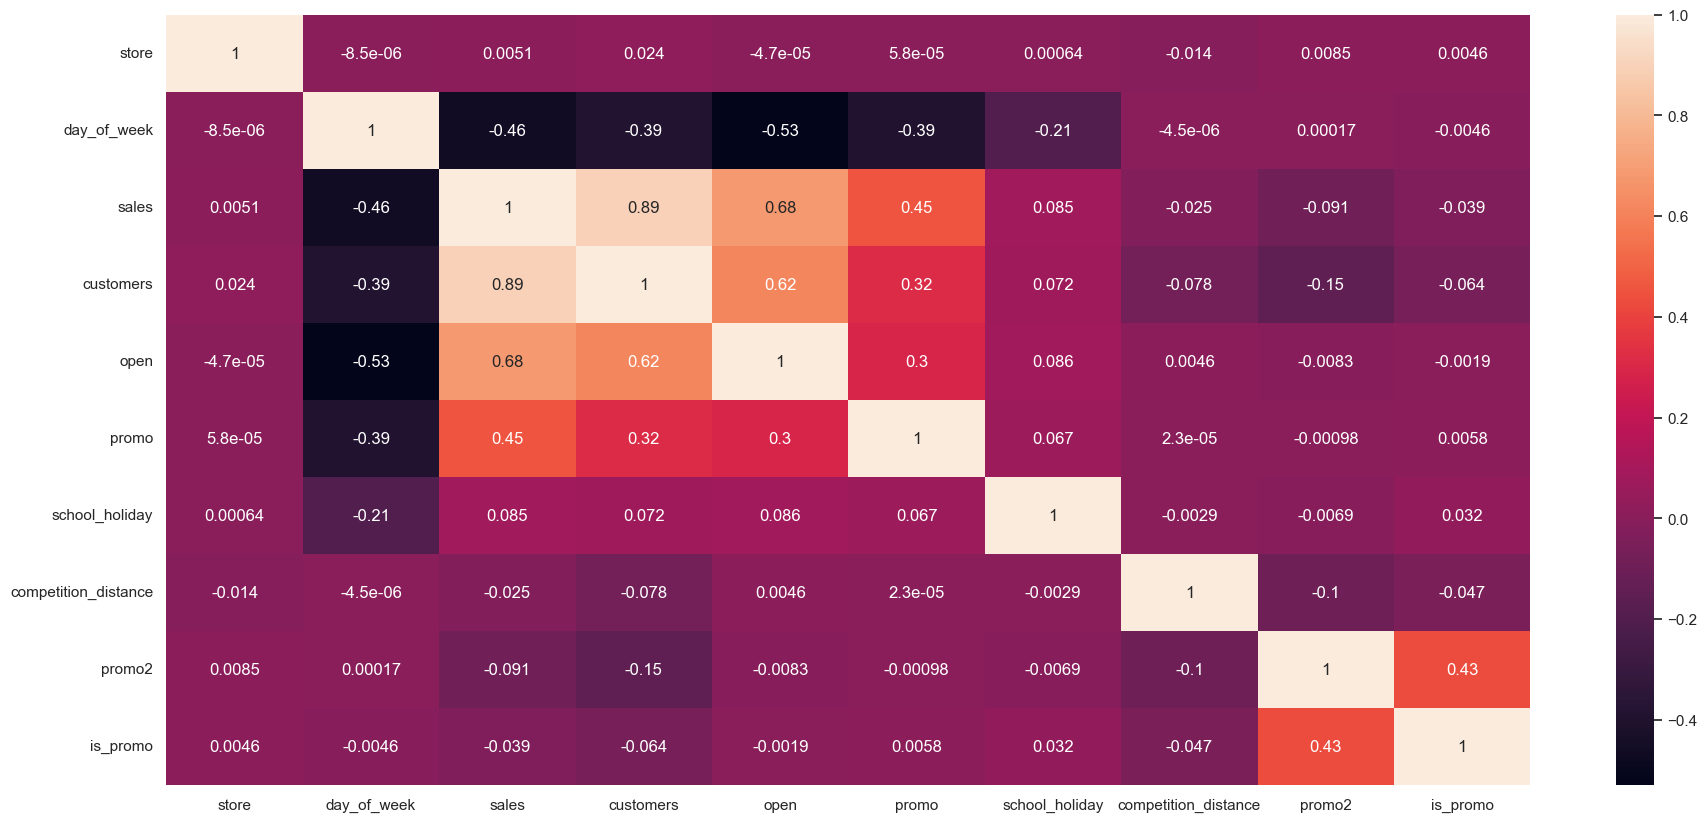

time: 750 ms (started: 2023-07-08 07:23:38 -03:00)


In [35]:
correlation = num_attributes.corr(method='pearson')
sns.heatmap(correlation, annot=True);

## 4.3.2 Categorical Attributes

<Axes: >

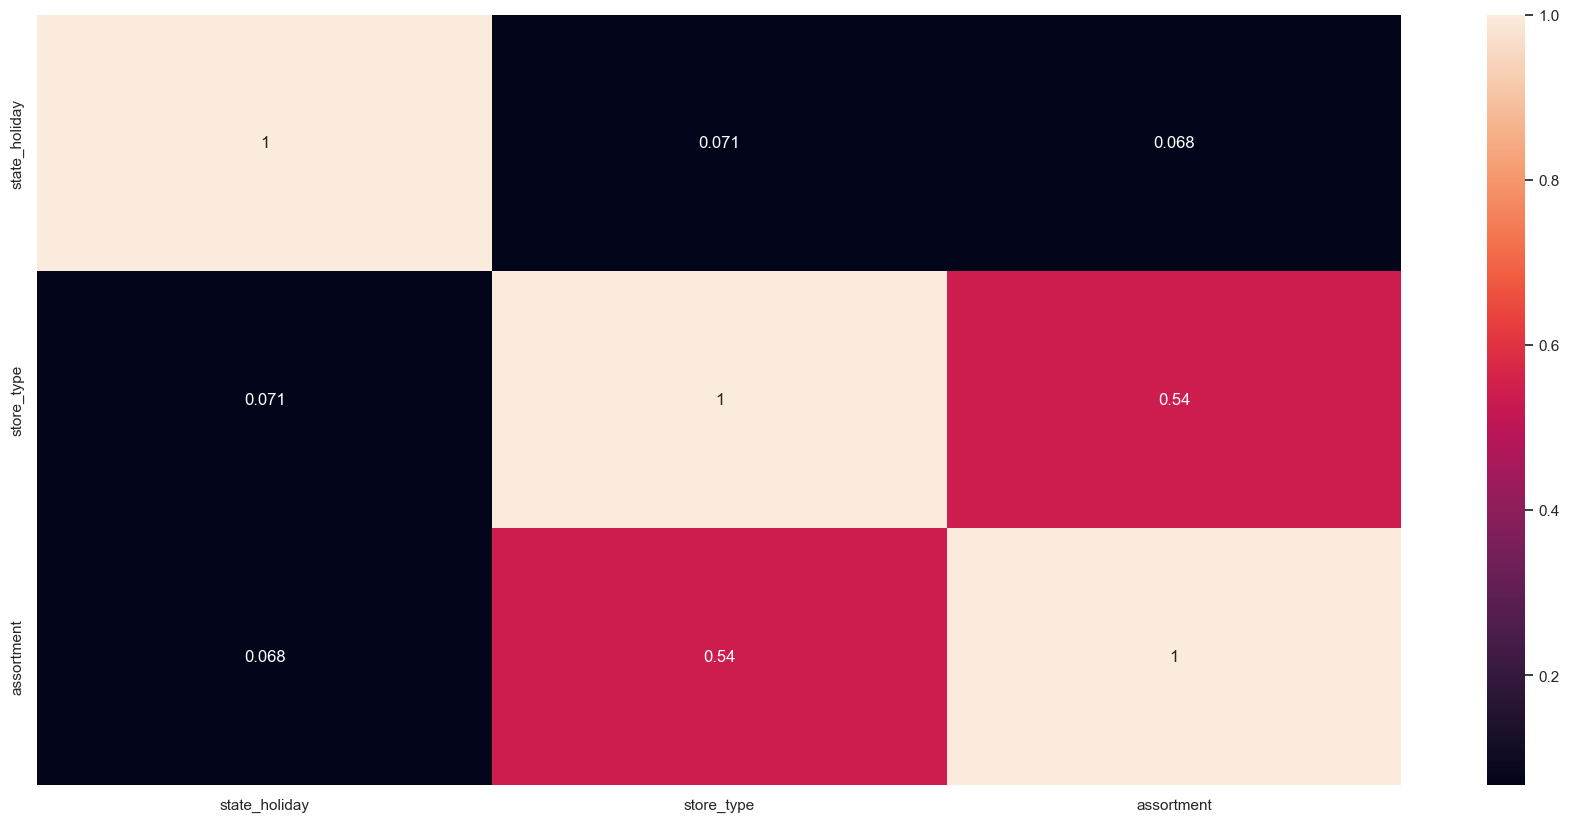

time: 1.34 s (started: 2023-07-08 08:02:04 -03:00)


In [97]:

# only categorical data
a = df4.select_dtypes( include='object')

# calculate cramer v
a1 = cramer_v(a['state_holiday'],a['state_holiday'])
a2 = cramer_v(a['state_holiday'],a['store_type'])
a3 = cramer_v(a['state_holiday'],a['assortment'])

a4 = cramer_v(a['store_type'],a['state_holiday'])
a5 = cramer_v(a['store_type'],a['store_type'])
a6 = cramer_v(a['store_type'],a['assortment'])

a7 = cramer_v(a['assortment'],a['state_holiday'])
a8 = cramer_v(a['assortment'],a['store_type'])
a9 = cramer_v(a['assortment'],a['assortment'])

# final data set
d = pd.DataFrame( {'state_holiday': [a1, a2, a3],
               'store_type': [a4, a5, a6],
               'assortment': [a7, a8, a9] })

d= d.set_index( d.columns)

sns.heatmap(d, annot=True)